In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit

## Preparations

In [2]:
gaz_zcta_years = [2000, 2010, 2012, 2013, 2014, 2015, 2016]
gaz_zcta = []
for y in gaz_zcta_years:
    fname = 'gaz_zcta' + str(y) + '.csv'
    gaz = pd.read_csv(fname, sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
    gaz_zcta.append(gaz)

print(len(gaz_zcta), '개 로드 완료!')

def which_gaz(year):
    test = [abs(year-zear) for zear in gaz_zcta_years]
    return gaz_zcta[test.index(min(test))]

7 개 로드 완료!


In [3]:
class Year_read:
    def __init__(self, prefix, year):
        self.year = year
        self.gaz = which_gaz(year)

        fname = prefix + str(year) + '.csv'
        self.zbp = pd.read_csv(fname, header=(0), dtype={'EMP':int, 'ZIP':str, 'rho':float})

In [4]:
years = np.arange(1999, 2017)
dat = []
for y in years:
    dat.append(Year_read('dat', y))

tflag = time()
for i,d in enumerate(dat):
    for row in d.zbp.iloc:
        idx = row.index_gaz
        if not np.isnan(idx):
            idx = int(idx)
            pop = d.gaz.iloc[idx].POP
            d.zbp.loc[row.name, 'POP'] = pop
    print(i+1, '/', len(dat), '(', d.year, ')', time()-tflag, 'sec'); tflag = time()
    
ykp = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp_5 = ykp.copy()
ykp_10 = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp_20 = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp.head()

1 / 18 ( 1999 ) 11.846415758132935 sec
2 / 18 ( 2000 ) 12.648149967193604 sec
3 / 18 ( 2001 ) 12.71844220161438 sec
4 / 18 ( 2002 ) 12.997206926345825 sec
5 / 18 ( 2003 ) 13.24305272102356 sec
6 / 18 ( 2004 ) 12.95777440071106 sec
7 / 18 ( 2005 ) 13.413734436035156 sec
8 / 18 ( 2006 ) 13.451281070709229 sec
9 / 18 ( 2007 ) 13.761756181716919 sec
10 / 18 ( 2008 ) 13.836256504058838 sec
11 / 18 ( 2009 ) 13.382614135742188 sec
12 / 18 ( 2010 ) 13.486112117767334 sec
13 / 18 ( 2011 ) 13.2683265209198 sec
14 / 18 ( 2012 ) 13.071362018585205 sec
15 / 18 ( 2013 ) 13.480355024337769 sec
16 / 18 ( 2014 ) 13.426236629486084 sec
17 / 18 ( 2015 ) 13.490121603012085 sec
18 / 18 ( 2016 ) 13.544083833694458 sec


,Y,GEO_TTL,k,P
0,1999,"Aaronsburg, PA",1,1091.0
1,1999,"Abbeville, AL",1,6991.0
2,1999,"Abbeville, GA",1,3870.0
3,1999,"Abbeville, LA",1,24760.0
4,1999,"Abbeville, MS",1,2272.0


In [151]:
from scipy.stats import ks_2samp

class kp_data: # alpha = 5
    def __init__(self, pKS, k=None, P=None, df=None, as_df=True):
        self.pKS = pKS
        if as_df: self.df = df
        else: self.df = pd.DataFrame({'k':k, 'P':P})
        self.numpoints = len(df)
    
    def fit(self, ltrim=1, rtrim=1):
        g = self.df.groupby(['k'])
        k_fit = list(g.indices)
        P_avg = g['P'].mean()
        
        if  rtrim is not None: rtrim = -rtrim
        fitfunc = lambda x,a,b : a*(x**b)
        res, cov = curve_fit(fitfunc, k_fit[ltrim:rtrim], P_avg[ltrim:rtrim])
        P_fit = fitfunc(k_fit, *res)

        stdvec = np.sqrt(np.diag(cov))
        Rsq = np.corrcoef(np.log(P_avg[1:-1]), np.log(P_fit[1:-1]))[0,1]**2
        
        self.df_avg = pd.DataFrame({'k':k_fit, 'P':P_avg})
        self.df_fit = pd.DataFrame({'k':k_fit, 'P':P_fit})
        self.fit_result = res
        self.stdvec = stdvec
        self.Rsq_exp = Rsq

## Read : Mind the $\alpha$ value

In [204]:
meta_KS = []

pKS_set = 0.1 * np.arange(1,10)
for i in range(len(pKS_set)):
#     fname = 'kP_KS%02d_alpha_10.csv' % (i+1)
    fname = 'kP_KS%02d.csv' % (i+1)
    df = pd.read_csv(fname, sep=',', header=(0))
    kp = kp_data(pKS_set[i], df=df)
    meta_KS.append(kp)

## Analysis

In [205]:
for kp in meta_KS:
    kp.fit(rtrim=1)

In [206]:
infotext = lambda pKS, num, beta, std, Rsq: '%.1f ∥ %d  | %.2f |  %.2f  | %.2f' % (pKS, num, beta, std, Rsq)
print('pKS ∥#Points |  β  | σ(1/β) |  R²')
print('======================================')
# print('%.1f ∥ %d | %.2f |  %.2f  | %.2f' % (0, 303701, 0.81, 0.14, 0.93)
#       + '  ← No point discarded/reduced')
for kp in meta_KS:
    print(infotext(kp.pKS, kp.numpoints, 1/kp.fit_result[1], kp.stdvec[1], kp.Rsq_exp))
# print(infotext(1, 18901, 0.75, 0.26, 0.92) + '  ← 1 City = 1 Point (Represented by Median)')

pKS ∥#Points |  β  | σ(1/β) |  R²
0.1 ∥ 19269  | 0.48 |  0.30  | 0.93
0.2 ∥ 19118  | 0.49 |  0.30  | 0.93
0.3 ∥ 19040  | 0.46 |  0.32  | 0.92
0.4 ∥ 18962  | 0.46 |  0.32  | 0.92
0.5 ∥ 18904  | 0.46 |  0.32  | 0.92
0.6 ∥ 18900  | 0.46 |  0.32  | 0.91
0.7 ∥ 18849  | 0.46 |  0.32  | 0.92
0.8 ∥ 18844  | 0.48 |  0.32  | 0.91
0.9 ∥ 18843  | 0.47 |  0.32  | 0.91


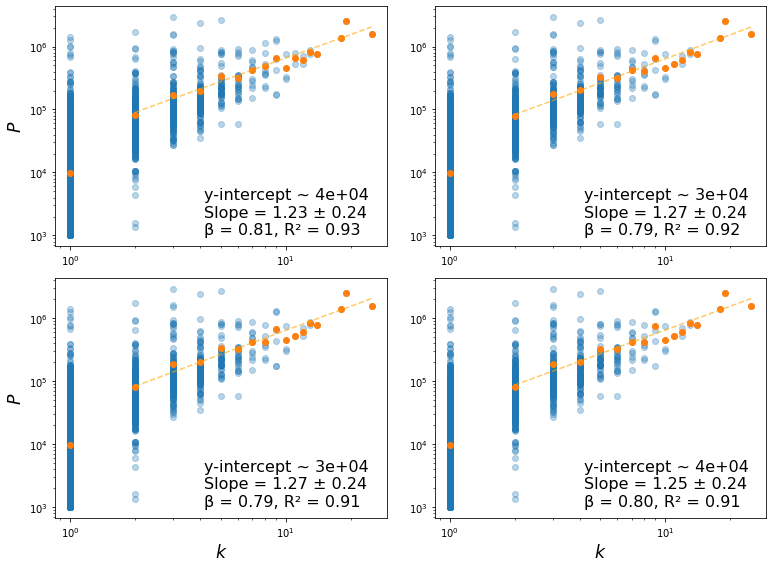

In [214]:
custom_pKS = [0.2, 0.4, 0.6, 0.8]
custom_kp = [kp for kp in meta_KS for pKS in custom_pKS
             if abs(kp.pKS-pKS) < 1e-4]

fig, axes = plt.subplots(2, 2, figsize=(11,8))
fs_title = 20
fs_axislabel = 'xx-large'
fs_text = 16

axes = np.concatenate((axes[0], axes[1]))
axes[0].set_ylabel('$P$', fontsize=fs_axislabel)
axes[2].set_ylabel('$P$', fontsize=fs_axislabel)
axes[2].set_xlabel('$k$', fontsize=fs_axislabel)
axes[3].set_xlabel('$k$', fontsize=fs_axislabel)
for ax, kp in zip(axes, custom_kp):
    ax.set_xscale('log'); ax.set_yscale('log')
#     ax.set_title('$p_{KS}=$%.1f' % kp.pKS, fontsize=fs_title)    
    
    ax.scatter(kp.df['k'], kp.df['P'], alpha = 0.3)    
    ax.scatter(kp.df_avg['k'], kp.df_avg['P'])
    
    kp.fit(rtrim=None); lt = 1
    ax.plot(kp.df_fit['k'][lt:], kp.df_fit['P'][lt:], ls='--', color='orange', alpha=0.6)
#     kp.fit(rtrim=1); lt, rt = 1, 2
#     ax.plot(kp.df_fit['k'][lt:-rt], kp.df_fit['P'][lt:-rt], ls='--', color='red', alpha=0.6)
#     kp.fit(rtrim=2); lt, rt = 1, 2
#     ax.plot(kp.df_fit['k'][lt:-rt], kp.df_fit['P'][lt:-rt], ls='--', color='deeppink', alpha=0.6)
    
    a, b = kp.fit_result
    s, r = kp.stdvec[1], kp.Rsq_exp
    txt1 = 'y-intercept ~ %.0e' % (a)
    txt2 = 'Slope = %.2f ± %.2f' % (b, s)
    txt3 = 'β = %.2f, R² = %.2f' % (1/b, r)
    ax.annotate('\n'.join([txt1, txt2, txt3]), (0.45, 0.05), xycoords='axes fraction', fontsize=fs_text)

plt.tight_layout()
plt.show()